# Earthquake prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("train.csv",
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

print('There are {} measurements in the file.'.format(len(train)))

There are 629145480 measurements in the file.


## Plot the data measurements (sampled at 1/50)

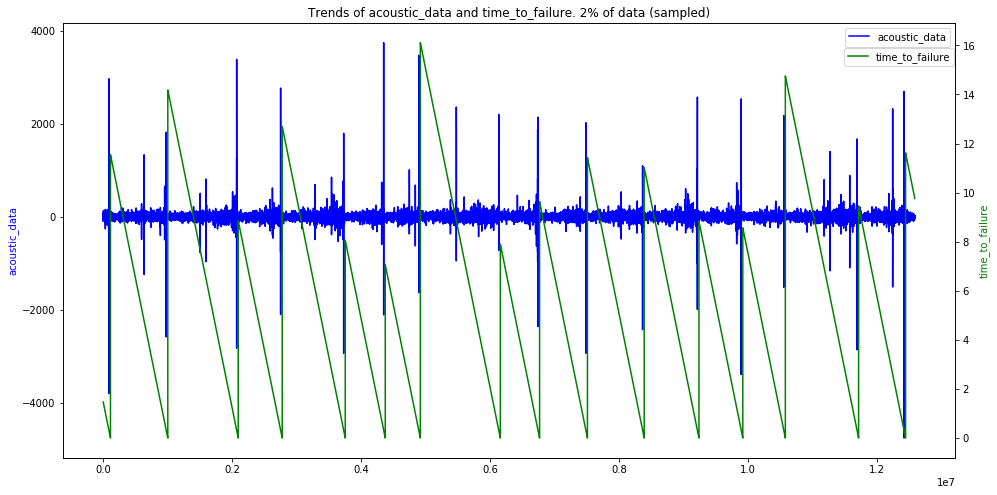

In [2]:


train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small


In [9]:
X_train = train.acoustic_data.values
y_train = train.time_to_failure.values

ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)

train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)


[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


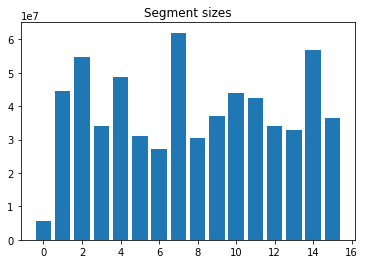

In [10]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

## How many events?

In [4]:
time_0 = train['time_to_failure'].min()
events = (train['time_to_failure']<time_0+9e-9).astype(int)
n_events = sum(events)
print('There are {} events in the data.'.format(n_events))

There are 16 events in the data.


# Summarized data

Read data in chunks of 10.000 rows, and summarize the chunks. 


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time


reader = pd.read_csv("train.csv",
                    dtype={'acoustic_data': np.int16, 'time_to_failure': np.float16},
                    chunksize=10000)

summary= 'meanAudio stdAudio maxAudio maxTime minAudio minTime q75Audio q25Audio event n'.split()
summarized_data = np.zeros((62915,len(summary)))
i = 0
start_time = time.time()
for df in reader:
    mean = df.mean()
    std = df.std()
    maxi = df.max()
    mini = df.min()
    q75 = df.quantile(.75)
    q25 = df.quantile(.25)
    summarized_data[i,0] = mean[0]
    summarized_data[i,1] = std[0]
    summarized_data[i,2] = maxi[0]
    summarized_data[i,3] = maxi[1]
    summarized_data[i,4] = mini[0]
    summarized_data[i,5] = mini[1]
    summarized_data[i,6] = q75[0]
    summarized_data[i,7] = q25[0]

    summarized_data[i,9] = len(df)
    i=i+1
    if(i%10000==0):
        print(i)
summarized_data = pd.DataFrame(summarized_data,columns=summary)
summarized_data['event'] = (summarized_data['minTime'].diff()>2).astype(int)
summarized_data.to_csv('summarized_data_10000.csv')
print('This took {:.2f} seconds to process'.format(time.time() - start_time))

10000


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# Plot chunk summaries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
chunks = pd.read_csv("summarized_data_10000.csv")
print('There are {} chunks in the file.'.format(len(chunks)))

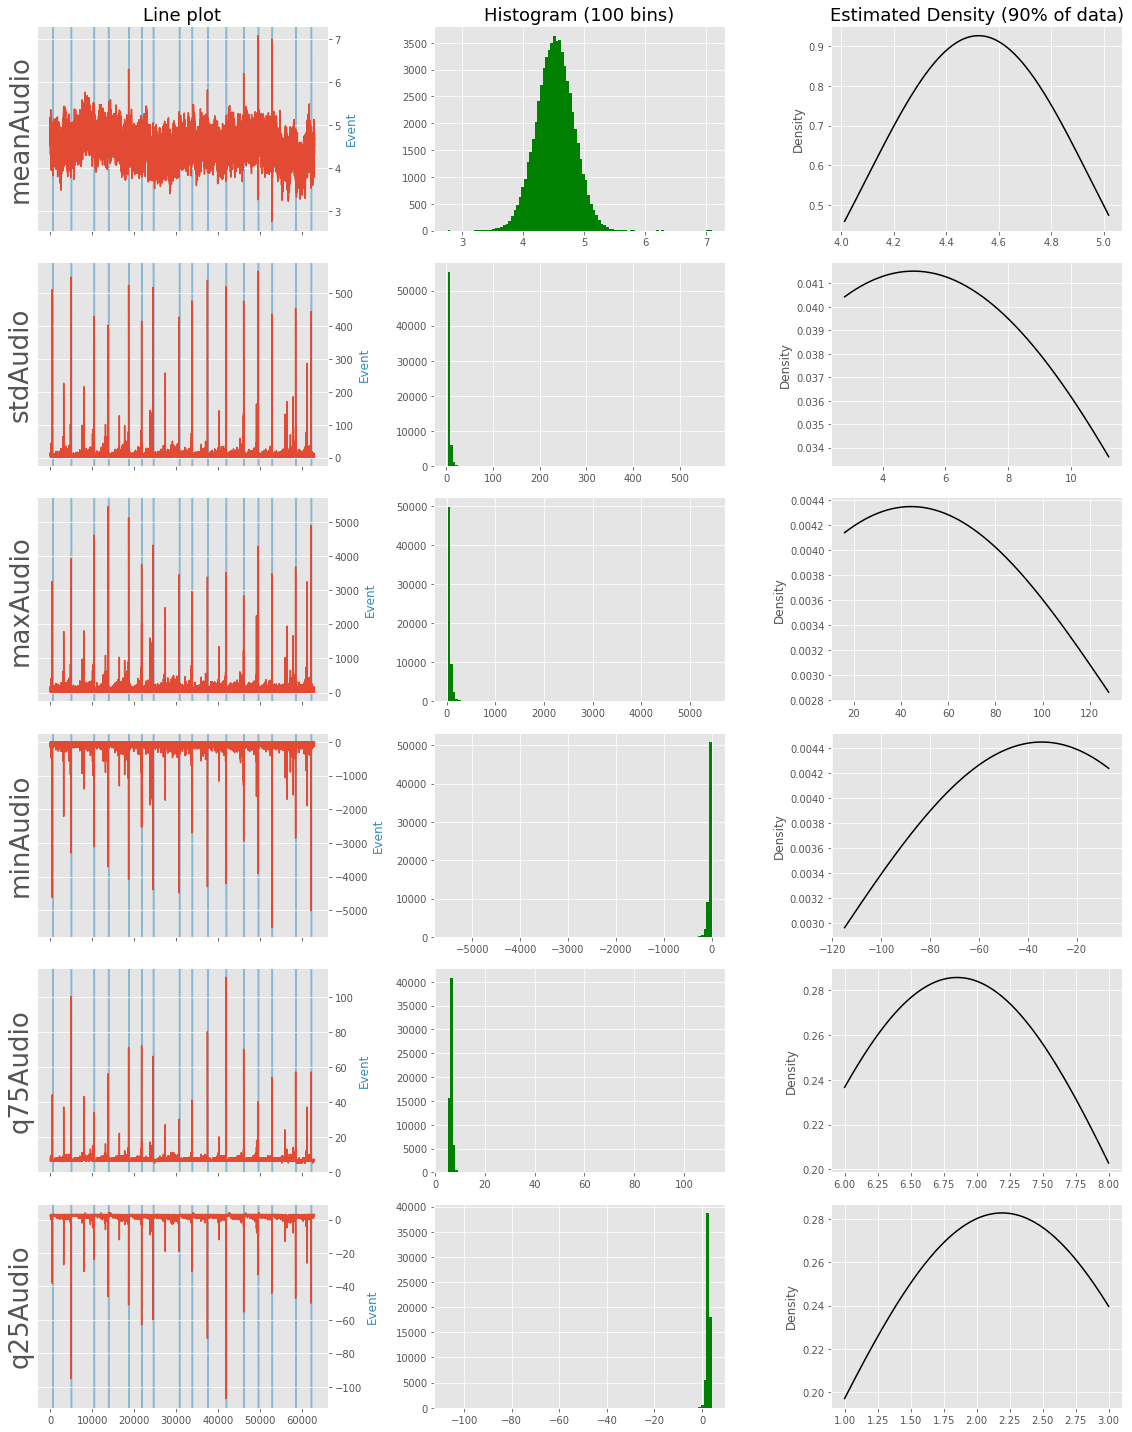

In [99]:
plt.style.use('ggplot')
summary= 'meanAudio stdAudio maxAudio minAudio q75Audio q25Audio'.split()
fig, ax = plt.subplots(len(summary),3,figsize=(16,20))
i=0
for s in summary:
    
    ax2 = ax[i,0].twinx()
    chunks['event'].plot(color=list(plt.rcParams['axes.prop_cycle'])[1]['color'],alpha=0.5,ax=ax[i,0])
    ax[i,0].grid(False)
    ax[i,0].tick_params(axis='y',labelleft='off',left='off')
    ax[i,0].set_ylim([0.1,1])
    chunks[s].plot(ax = ax2,alpha=1)
    ax2.set_ylabel('Event',color=list(plt.rcParams['axes.prop_cycle'])[1]['color'])
    chunks[s].hist(color='g',ax = ax[i,1],bins=100)
    q25 = chunks[s].quantile(.05)
    q75 = chunks[s].quantile(.95)
    rang=np.linspace(q25,q75,num=1000)
    chunks[s].plot.kde(color='k',ax=ax[i,2],bw_method=1,ind=rang)
    ax[i,0].set_ylabel(s,fontsize=26)
    i=i+1
    
ax[0,0].set_title('Line plot',fontsize=18)
ax[0,1].set_title('Histogram (100 bins)',fontsize=18)
ax[0,2].set_title('Estimated Density (90% of data)',fontsize=18)
plt.tight_layout()
plt.savefig('summary.png',dpi=300)
